<a href="https://colab.research.google.com/github/chandagrover/Machine-Learning/blob/master/4QED_SMILEVAE_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Installs and Imports**

In [1]:
# 10 tricks for a better Google Colab experience
# https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82
# %load_ext google.colab.data_table

In [2]:
!sudo apt-get install software-properties-common
!sudo add-apt-repository ppa:ubuntu-toolchain-r/test
!sudo apt-get update
!sudo apt-get install gcc-4.9
!sudo apt-get upgrade libstdc++6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
software-properties-common is already the newest version (0.96.24.32.14).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
 Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

 More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://ppa.launchpad.net/c2d4u.team

In [3]:
# !pip install keras==2.2.4
%tensorflow_version 1.x
import keras
import tensorflow as tf
print("Keras: %s"%keras.__version__)
print("Tensorflow: %s"%tf.__version__)


TensorFlow 1.x selected.


Using TensorFlow backend.


Keras: 2.3.1
Tensorflow: 1.15.2


In [4]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')


--2021-01-07 07:58:39--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2021-01-07 07:58:39--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ failed with initial froz

In [5]:
# !strings /usr/lib/x86_64-linux-gnu/libstdc++.so.6 | grep GLIBCXX

In [6]:
# General Imports
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

# RDKIT Imports
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import re
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# FOR VAE Architecture 
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
print("RDKit: %s"%rdkit.__version__)
# Checking if GPU is enabled or not
tf.test.gpu_device_name()



RDKit: 2020.09.3


'/device:GPU:0'

# **Data Fetching**

In [7]:
# mount Google Drive
from google.colab import drive
drive.mount('/drive')
WEIGHTS_FOLDER = 'sample_data/weights/'
import csv
smifile ='/drive/My Drive/ZINC/Data/ZINC_Data/SMILEWithProp.csv'      #"sample_data/SMILEWithoutProp.csv"
df = pd.read_csv(smifile, delimiter = ",", header='infer', encoding='utf-8')
# smifile ='/drive/My Drive/ZINC/Data/ZINC_Data/AAAA.smi'      
# df = pd.read_csv(smifile, delimiter = " ", header='infer', encoding='utf-8')
df.smiles = df.smiles.replace('\n','', regex=True)
data= pd.DataFrame(df[df['smiles'].str.len()<60])
data=data.reset_index(drop=True)
NUM_SMILES = len(data)
print(NUM_SMILES)
data.head()


Mounted at /drive
7732


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [8]:
# print(type(data.smiles.items))
# data= data[data['smiles'].str.len()<60]
# print(data.smiles.count())
print(len(data))

7732


In [9]:
smiles_train, smiles_test = train_test_split(data, test_size=0.2, shuffle=False)
print("Training data shape", smiles_train.shape)
print("Testing Data shape", smiles_test.shape)
print("Total Data Points", NUM_SMILES)

Training data shape (6185, 4)
Testing Data shape (1547, 4)
Total Data Points 7732


In [11]:
# logP_train = smiles_train['logP']
# logP_test = smiles_test['logP']

qed_train=smiles_train['qed']
qed_test=smiles_test['qed']

# SAS_train=smiles_train['SAS']
# SAS_test=smiles_test['SAS']

train=np.array([qed_train])   #logP_train, qed_train, SAS_train
test= np.array([qed_test])             #logP_test, qed_test, SAS_test
y_train_property=train.transpose()
y_test_property=test.transpose()
#Labels for the Smiles String. We will deal with three properties values.
print("Training Data Property shape", y_train_property.shape)
print("Testing Data Property Shape", y_test_property.shape)
# print(qed_train[1])

Training Data Property shape (6185, 1)
Testing Data Property Shape (1547, 1)


### **Vector Representation of Data**

In [12]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
# embed = max([len(smile) for smile in data.smiles]) + 5
embed = max([len(smile) for smile in data.smiles])+2
# print(char_to_int)
print(int_to_char)
print(len(charset), embed)
# print(embed)

{0: '(', 1: '@', 2: '\\', 3: 'S', 4: '#', 5: 'c', 6: 's', 7: '3', 8: 'n', 9: 'B', 10: 'N', 11: 'H', 12: '5', 13: 'C', 14: 'o', 15: '+', 16: 'O', 17: '!', 18: ')', 19: 'E', 20: '=', 21: '1', 22: 'I', 23: '-', 24: ']', 25: '[', 26: 'l', 27: 'P', 28: 'r', 29: '/', 30: 'F', 31: '4', 32: '2'}
33 61


In [13]:
def vectorize(smiles):
        onehot_flatList=[[]]
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        # print(one_hot.shape)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,:,:]

X_train= vectorize(smiles_train['smiles'].values)
X_test = vectorize(smiles_test['smiles'].values)
print(X_train.shape)
print(X_test.shape)

(6185, 61, 33)
(1547, 61, 33)


### **Checking if Vectorization works!!**

Molecule Index= 900 	Length = 58 	Smile= COc1cc2c(cc1OC)[C@H](C(=O)[O-])[C@H](c1cccc(Cl)c1)N(C)C2=O


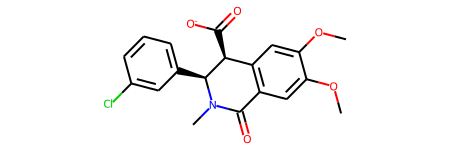

In [14]:
idx=900
print("Molecule Index=", idx,"\tLength =",len(smiles_train['smiles'][idx]),"\tSmile=", (smiles_train['smiles'][idx]))
mol = Chem.MolFromSmiles(smiles_train['smiles'][idx])
mol

58
COc1cc2c(cc1OC)[C@H](C(=O)[O-])[C@H](c1cccc(Cl)c1)N(C)C2=O


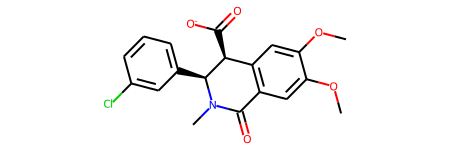

In [15]:
# Going back from vectorized form back to a readable string
smi="".join([int_to_char[idx] for idx in np.argmax(X_train[idx,:,:], axis=1)])
# String After Tructation of extra symbols
smi = re.sub('[!E]', '', smi)
print(len(smi))
print(smi)
mol = Chem.MolFromSmiles(smi)
mol

In [16]:
mol_size_x=X_train.shape[1]
mol_size_y=X_train.shape[2]
orig_dim = mol_size_x * mol_size_y
# print(mol_size_x)
# print(mol_size_y)
print(orig_dim)
X_train = np.reshape(X_train, [-1, orig_dim])
X_test = np.reshape(X_test, [-1, orig_dim])
# print(type(X_train))
# print(X_train.shape)
# print(X_train.shape[1])

2013


# **VAE**

In [37]:
# Network Parameters
INPUT_DIM=(orig_dim,)   # SMILES dimension
intermediate_dim=512
BATCH_SIZE=5
Z_DIM=40# Dimension of the latent vector (z)
epochs=50
pre_trained=False

### **Encoder**

In [38]:
# ENCODER
def build_vae_encoder(input_dim, output_dim):
  
  # Clear tensorflow session to reset layer
  global K
  K.clear_session()
  
  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  
  #Intermediate layer
  x = Dense(intermediate_dim,activation='relu', name='hidden')(encoder_input)
 
  #Model Output
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer in the model
  encoder_output = Lambda(sampling, output_shape=(2,), name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, Model(encoder_input, encoder_output, name='encoder')



### **Decoder**

In [39]:
# Decoder
def build_decoder(input_dim, output_dim):

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')
  
  #Intermediate Layer
  x = Dense(intermediate_dim, activation='relu', name='hidden')(decoder_input)

    # Define model output
  decoder_output = Dense(output_dim, activation='sigmoid', name='decoder_lastlayer')(x)


  return decoder_input, decoder_output, Model(decoder_input, decoder_output, name='decoder')




### **Predictor**

In [40]:
def create_predictor_linear():
    '''
    Creates a regressor that estimates property values 
    from latent variables.
    '''
    predictor_input = layers.Input(shape=(Z_DIM,), name='predictor_input', dtype='float32')
    
    x = layers.Dense(10, activation='relu', name='hidden')(predictor_input)
    x = layers.Dense(1, activation='linear', name='predictor_lastlayer', dtype='float32')(x)
    return Model(predictor_input, x, name='predictor')


### **Creating the OverAll Model**

In [41]:
# Model Creation 
def create_model():

  #Creating Encoder
  vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,                                                                                         output_dim = Z_DIM)
# vae_encoder.summary()
  
  
  #Creating Decoder
  vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM, output_dim=orig_dim)
# vae_decoder.summary()

  #Creating the Predictor
  predictor = create_predictor_linear()
  t_predicted = predictor(mean_mu)
  


  #Creating the VAE Model 
  vae_input = vae_encoder_input

  # Output will be the output of the decoder. The term - decoder(encoder_output) 
  vae_output = vae_decoder(vae_encoder_output)

  # # VAE Model with Predictor
  vae_predictor = Model(vae_input, [vae_output,t_predicted], name='VAE_with_Predictor')
# VAE Model without Property Predictor
  # vae_with_predictor = Model(vae_input, vae_output, name='VAE_without_Predictor')



  return vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder, vae_decoder_input, vae_decoder_output, vae_decoder,predictor, vae_input, vae_output, vae_predictor

#Creating the overall Model
encoder_input, encoder_output,  mean_mu, log_var, encoder, decoder_input, decoder_output, decoder, predictor, vae_input, vae_output, vae_predictor = create_model()



### **VAE Loss Function**

In [42]:
#VAE Loss Function
def vae_loss(vae_input, vae_output):
  reconstruction_loss = binary_crossentropy(vae_input, vae_output)
  reconstruction_loss = reconstruction_loss * orig_dim
    
  kl_loss = 1 + log_var - K.square(mean_mu) - K.exp(log_var)
  kl_loss = K.sum(kl_loss, axis=-1)    
  kl_loss = kl_loss * -0.5
  kl_weight=0.5
  reconst_weight=0.5
    
  # vae_loss_val = K.mean(reconstruction_loss + kl_loss)
  vae_loss_val=kl_weight * kl_loss + reconst_weight * reconstruction_loss
  return vae_loss_val


**Plotting all models**

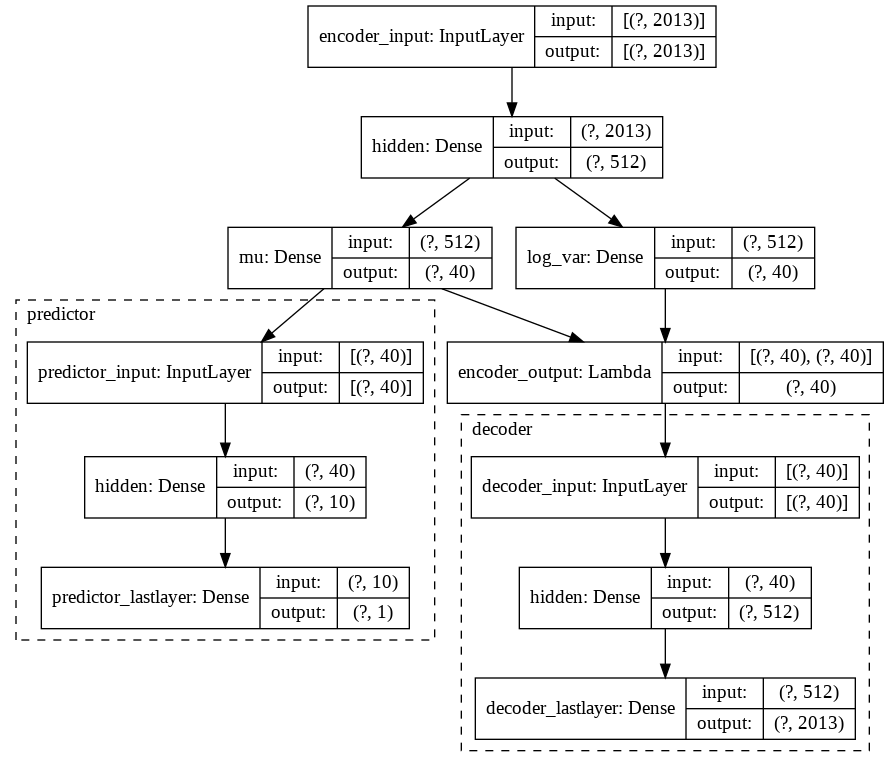

In [43]:
# Plot the Encoder Model
plot_model(encoder, to_file='/drive/My Drive/ZINC/Models/OnlyQED/Diagram/only_encoder.png', show_shapes=True, show_layer_names=True)  #, expand_nested=True

# Plot the Decoder Model
plot_model(decoder, to_file='/drive/My Drive/ZINC/Models/OnlyQED/Diagram/only_decoder.png', show_shapes=True, show_layer_names=True)    #, expand_nested=True

# #Plot the Predictor Model
plot_model(predictor, to_file='/drive/My Drive/ZINC/Models/OnlyQED/Diagram/only_predictor.png', show_shapes=True, show_layer_names=True)    #, expand_nested=True

# Plot the VAE-Predictor Model
plot_model(vae_predictor, to_file='/drive/My Drive/ZINC/Models/OnlyQED/Diagram/smilesvae_with_QEDpredictor.png', show_shapes=True, show_layer_names=True, expand_nested=True)   #, expand_nested=False



**Checkpoint**

In [44]:
# Creating Model Checkpoint for training...

checkpoint_path = "/drive/My Drive/ZINC/Models/OnlyQED/Weights/train_ckpt/cp.ckpt"
new_check_path="/drive/My Drive/ZINC/Models/OnlyQED/Weights/VAE_With_QEDPredictor{epoch:02d}-{val_loss:.2f}.h5"           #'VAE_Predictor{epoch:02d}.h5'
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=new_check_path, verbose=1, save_weights_only=False, save_best_only=True)   #, save_freq=5

# Loading weights from the latest checkpoints
#get the latest checkpoint file
checkpoint_dir = os.path.dirname(new_check_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

### **Training or Loading the VAE Model**

In [45]:
pre_trained=False
epochs=100
if __name__ == '__main__':          
#     Train the Variational AutoEncoder
    if pre_trained==False:
      vae_predictor.compile(optimizer='adam', 
                      loss=[vae_loss, 'mean_squared_error'], 
                      loss_weights=[3.0, 1.0]     
                      ) 
      history = vae_predictor.fit(x=X_train,
                            y=[X_train,y_train_property], 
                            epochs=epochs,
                            validation_data=(X_test, [X_test, y_test_property]),
                            verbose=2,
                            callbacks=[cp_callback] )  
      vae_predictor.save(new_check_path)
    else:
      vae_predictor.load_weights(new_check_path)
      history = vae_predictor.fit(x=X_train,
                            y=[X_train,y_train_property], 
                            epochs=epochs,
                            validation_data=(X_test, [X_test, y_test_property]),
                            verbose=2,
                            callbacks=[cp_callback]) 
      vae_predictor.save(new_check_path)
    

Train on 6185 samples, validate on 1547 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 258.51276, saving model to /drive/My Drive/ZINC/Models/OnlyQED/Weights/VAE_With_QEDPredictor01-258.51.h5
6185/6185 - 1s - loss: 349.7986 - decoder_loss: 116.4428 - predictor_loss: 0.0668 - val_loss: 258.5128 - val_decoder_loss: 86.1476 - val_predictor_loss: 0.0246
Epoch 2/100

Epoch 00002: val_loss improved from 258.51276 to 244.05983, saving model to /drive/My Drive/ZINC/Models/OnlyQED/Weights/VAE_With_QEDPredictor02-244.06.h5
6185/6185 - 1s - loss: 250.3243 - decoder_loss: 83.4377 - predictor_loss: 0.0285 - val_loss: 244.0598 - val_decoder_loss: 81.3228 - val_predictor_loss: 0.0336
Epoch 3/100

Epoch 00003: val_loss improved from 244.05983 to 231.35583, saving model to /drive/My Drive/ZINC/Models/OnlyQED/Weights/VAE_With_QEDPredictor03-231.36.h5
6185/6185 - 1s - loss: 235.9199 - decoder_loss: 78.6262 - predictor_loss: 0.0412 - val_loss: 231.3558 - val_decoder_loss: 77.0970 - val_pr

In [46]:
# print(type(history))
# print(type(history.history))
print(history.history.keys())

dict_keys(['loss', 'decoder_loss', 'predictor_loss', 'val_loss', 'val_decoder_loss', 'val_predictor_loss'])


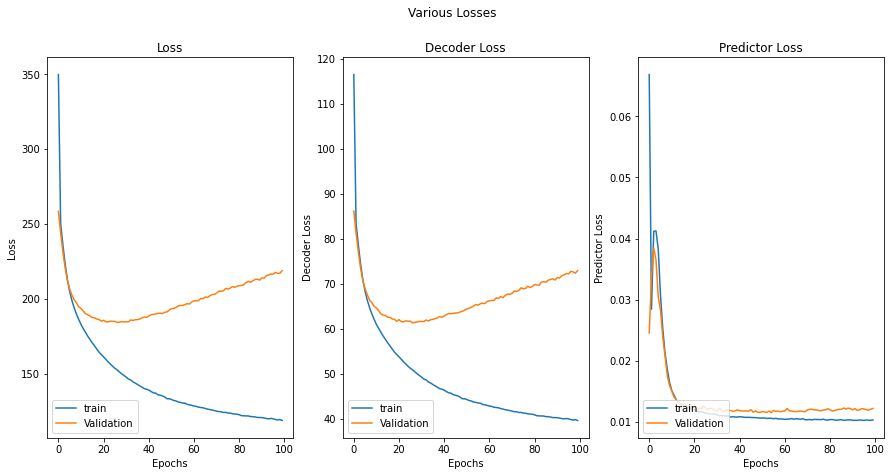

In [47]:
# summarize history for loss
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
fig.suptitle('Various Losses')


ax1.plot(history.history['loss'])
ax1.plot( history.history['val_loss'])
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['train', 'Validation'], loc='lower left')


ax2.plot(history.history['decoder_loss'])
ax2.plot(history.history['val_decoder_loss'])
ax2.set_title('Decoder Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Decoder Loss')
ax2.legend(['train', 'Validation'], loc='lower left')

ax3.plot(history.history['predictor_loss']) 
ax3.plot(history.history['val_predictor_loss'])
ax3.set_title('Predictor Loss')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Predictor Loss')
ax3.legend(['train', 'Validation'], loc='lower left')

# **Latent Space Visualization**

### **Each Component of latent space**

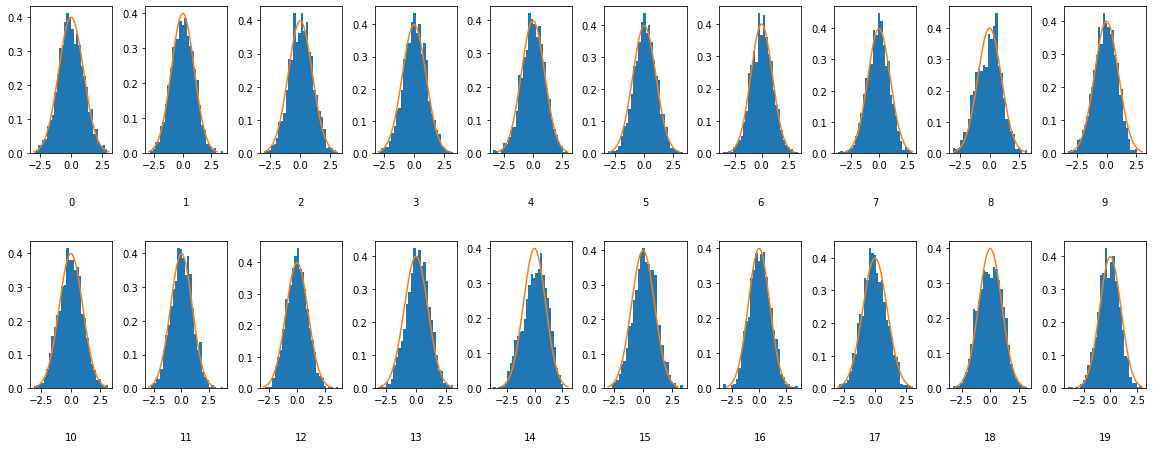

In [48]:
from scipy.stats import norm
# with graph.as_default():   # We are using this statement to reuse the last saved trained model
z_test = encoder.predict(X_test)

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(20):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 30)
    ax.axis('on')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

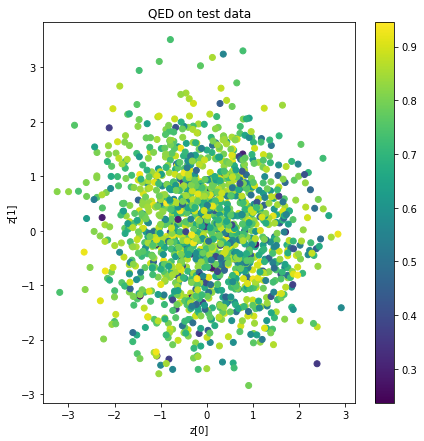

In [49]:
from sklearn.manifold import TSNE
z_mean = encoder.predict(X_test)
# print(z_mean)
model_name='/drive/My Drive/ZINC/Models/OnlyQED/Diagram/'
os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "VAESMILES_QEDLatent_mean.png")

# z_embedded = TSNE(n_components=2).fit_transform(z_mean)
plt.figure(figsize=(7,7))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=qed_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('QED on test data')
plt.savefig(filename)
plt.show()

# **Reconstruction**


In [50]:
# encoded, decoded and predicted data on test dataset

encoded_xtest=encoder.predict(X_test)
# predicted_xtest=predictor.predict(encoded_xtest)
decoded_xtest=decoder.predict(encoded_xtest)
print("Encoded data shape",encoded_xtest.shape)
# print("Predicted Property Data Shape",predicted_xtest.shape)
print("Reconstructed Test data Shape", decoded_xtest.shape)

# Reshaping the original and reconstructed test data
orig_test=X_test.reshape(len(X_test), mol_size_x, mol_size_y)
reconst_test = decoded_xtest.reshape(len(X_test), mol_size_x,mol_size_y)
print("Original Test Data Dimension",orig_test.shape)
print("Reconstructed Test Data Dimension", reconst_test.shape)

Encoded data shape (1547, 40)
Reconstructed Test data Shape (1547, 2013)
Original Test Data Dimension (1547, 61, 33)
Reconstructed Test Data Dimension (1547, 61, 33)


### **Reconstruction Original test data set**

1547 Original Valid Test Samples
8 Reconstructed Valid Test Samples
Molecule 29 Original Valid Cc1nc(-c2cccs2)sc1C(=O)N1CCNC(=O)C1
Molecule 29 Reconstructed Valid Cc1nc(-c2cc1cc2cc1C(=O)N2CC(C2)O)C1
Molecule 481 Original Valid Cc1ccc([C@H]2CCCC[NH+]2CC2=CCCOC2)cc1
Molecule 481 Reconstructed Valid Cc1ccc([C@@]2CCCC[NH+](CCC2C)CCCC)cc1
Molecule 491 Original Valid CS(=O)(=O)CCSCCCS
Molecule 491 Reconstructed Valid CS(=O)(=S)c1CCC1CS
Molecule 1119 Original Valid Cc1ccc(C(=O)N(C)CCOc2ccccc2F)cn1
Molecule 1119 Reconstructed Valid Cc1ccc(C(=O)N(C)CCCc2ccccc2F)cn1
Molecule 1320 Original Valid C[C@H](O)[C@H](C)SCC(=O)Nc1ccc(Cl)cn1
Molecule 1320 Reconstructed Valid C[C@H]1CC[C@@]1CCCCC(=O)Cc1ccc(Br)cc1
Molecule 1345 Original Valid Cc1cnc(Cl)nc1NCC1CC[NH+](C)CC1
Molecule 1345 Reconstructed Valid Cc1csc(C)cccNCCCC/C[NH+](C)CC1
Molecule 1355 Original Valid C[C@@H]1CCC[C@@H](C)N1S(=O)(=O)c1ccc(Br)cc1
Molecule 1355 Reconstructed Valid C[C@H+]1CCC[C@@H](CONN2(=O)CCO)c11cc(C2)cc1
Molecule 1446 Original

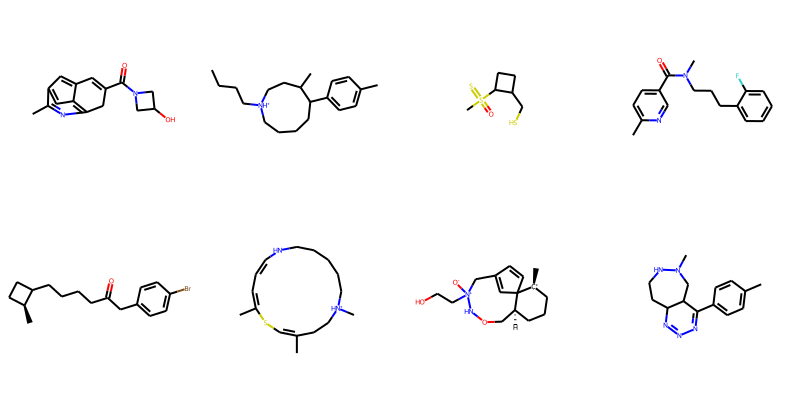

In [51]:
# Going back from vectorized form back to a readable string on original test data
IPythonConsole.ipython_useSVG=True 
mols_orig_test= []
smi_orig_test=[]
syntax_val={0:[], 1:[]}

for id in range(len(X_test)):
  smi="".join([int_to_char[idx] for idx in np.argmax(orig_test[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_orig_test.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_orig_test.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid SMiles" ,sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)
      # print(mol)
    except:
      print('Mol {} {}'.format(id+1, mol)) 


smi_orig_test_valid=[]
mols_orig_test_valid=[]
for item in syntax_val[1]:
  smi_orig_test_valid.append(smi_orig_test[item])
  mols_orig_test_valid.append(mols_orig_test[item])
# smi_orig_test_valid


print(len(mols_orig_test_valid), "Original Valid Test Samples")
# Draw.MolsToGridImage(mols_orig_test_valid, molsPerRow=4,subImgSize=(200,200))



### **Reconstruction on reconstructed test data**

from rdkit import RDLogger  
# Going back from vectorized form back to a readable string on original test data
#Reconstruction
syntax_val={0:[], 1:[]}
mols_reconst_test= []
smi_reconst_test=[]

RDLogger.DisableLog('rdApp.*')  

for id in range(len(X_test)):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_test[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_reconst_test.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_test.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Reconstructed Smile", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol, kekulize=False)
    except:
      # print('Mol {} {}'.format(id+1, mol)) 
      continue


smi_reconst_test_valid=[]
mols_reconst_test_valid=[]
smi_orig_test_valid=[]
mols_orig_test_valid=[]

print(len(syntax_val[1]), "Reconstructed Valid Test Samples")
for item in syntax_val[1]:
  smi_reconst_test_valid.append(smi_reconst_test[item])
  smi_orig_test_valid.append(smi_orig_test[item])

  mols_reconst_test_valid.append(mols_reconst_test[item])
  mols_orig_test_valid.append(mols_orig_test[item])
  print("Molecule", item, "Original Valid", smi_orig_test[item] )
  print("Molecule", item, "Reconstructed Valid", smi_reconst_test[item])

Draw.MolsToGridImage(mols_reconst_test_valid, molsPerRow=4,subImgSize=(200,200))



## **Reconstruction on Training data**

6185 Original Valid Training Samples
336 Reconstructed Valid Training Samples
Molecule 55 Original Valid CC[C@@H](NC(=O)[C@H](C)n1cccn1)c1ccc(C)c(F)c1
Molecule 55 Reconstructed valid CC[C@@H](NC(=O)[C@H](C)n1cccn1)c1ccc(C)c(F)c1
Molecule 67 Original Valid C[C@H](Cc1cccs1)N(C)C[C@@H]1CCCC[C@@H]1[NH3+]
Molecule 67 Reconstructed valid C[C@H](Cc1cccs1)N(C)C[C@@H]1CCCC[C@@H]1[NH3+]
Molecule 73 Original Valid C[C@H](CNC(=O)[C@H]1CC[NH2+][C@@H]1C)C[NH+]1CCCC1
Molecule 73 Reconstructed valid C[C@H](CNC(=O)[C@H]1CC[NH2+][C@@H]1C)C[NH+]1CCCC1
Molecule 76 Original Valid CC[C@@H](C)CNc1nc2ccc(Cl)cc2s1
Molecule 76 Reconstructed valid CC[C@@H](C)CNc1nc2ccc(Cl)cc2s1
Molecule 83 Original Valid CCC[C@@H]1CN(C(=O)C(=O)Nc2ccc(C)nc2Cl)CCO1
Molecule 83 Reconstructed valid CCC[C@@H]1CC(C(=O)C(=O)Nc2ccc(C)nc2CC)CCO1
Molecule 110 Original Valid CCOc1cccc(NC(=O)CCc2ccc(N)cc2)c1
Molecule 110 Reconstructed valid CCOc1cccc(NC(=O)CCc2ccc(N)cc2)c1
Molecule 142 Original Valid CCOCCCNC(=O)N[C@@H]1CCC[C@@H](CC)C1
Mole

/usr/local/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


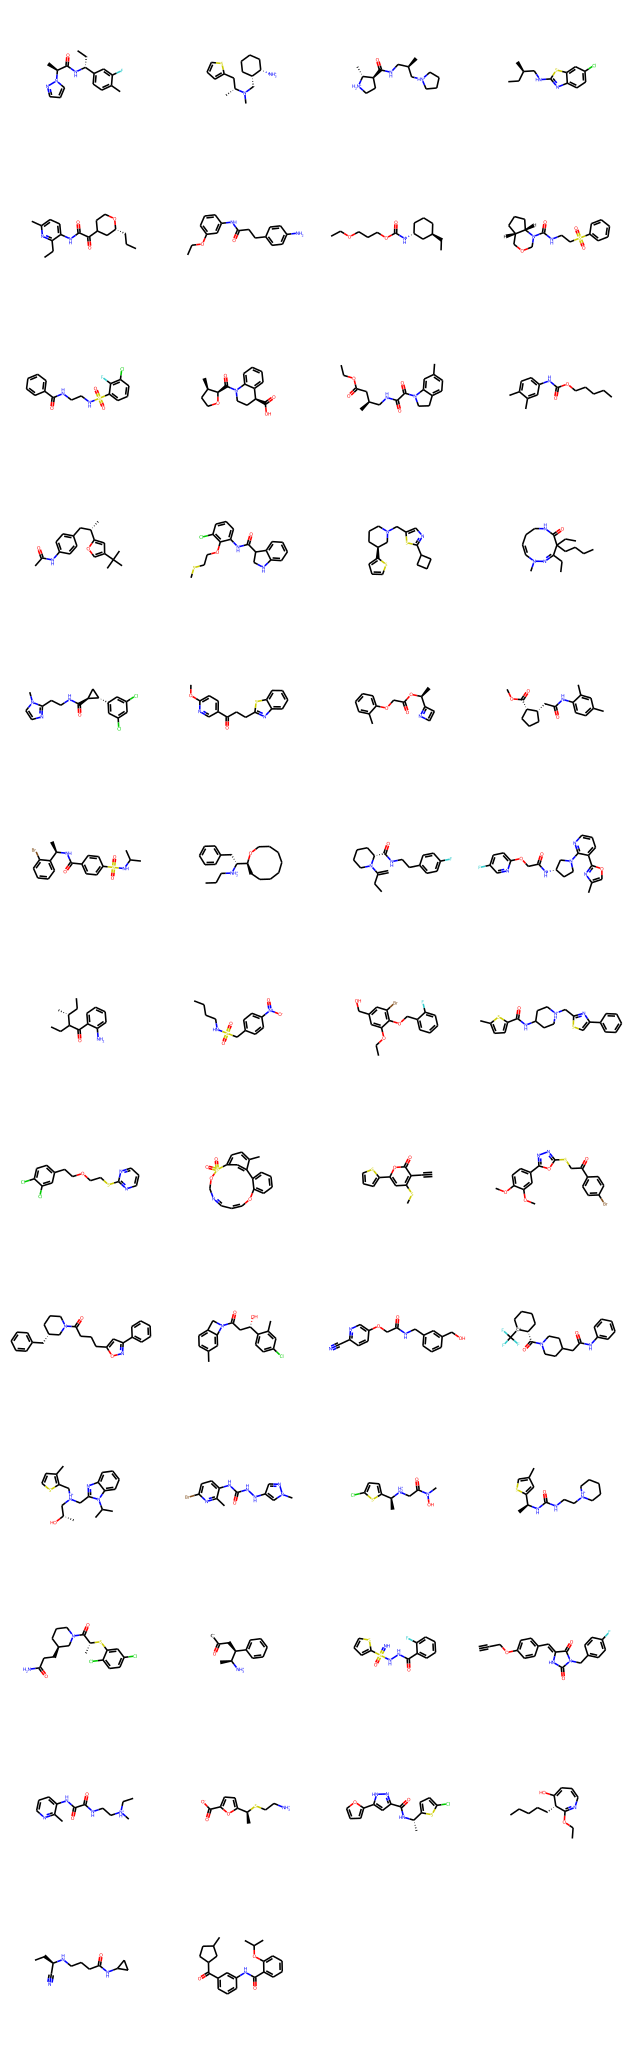

In [52]:
# encoded, decoded and predicted data on Training dataset

encoded_xtrain=encoder.predict(X_train)
# predicted_xtest=predictor.predict(encoded_xtrain)
decoded_xtrain=decoder.predict(encoded_xtrain)
# print(encoded_xtrain.shape)
# print(predicted_xtrain.shape)
# print(decoded_xtrain.shape)

# Reshaping the original and reconstructed train data
orig_train=X_train.reshape(len(X_train), mol_size_x, mol_size_y)
reconst_train = decoded_xtrain.reshape(len(X_train), mol_size_x,mol_size_y)
# print(orig_train.shape)
# print(reconst_train.shape)
# Going back from vectorized form back to a readable string on original training data

syntax_val={0:[], 1:[]}

smi_orig_train=[]
mols_orig_train= []

for id in range(len(X_train)):
  smi="".join([int_to_char[idx] for idx in np.argmax(orig_train[id,:,:], axis=1)])
  smi = re.sub('!|E',"", smi)
  smi_orig_train.append(smi)

  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_orig_train.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(mol), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)
    except:
      print('Mol {} {}'.format(id+1, mol)) 

smi_orig_train_valid=[]
mols_orig_train_valid=[]

for item in syntax_val[1]:
  smi_orig_train_valid.append(smi_orig_train[item].rstrip('\n'))
  mols_orig_train_valid.append(mols_orig_train[item])


print(len(mols_orig_train_valid), "Original Valid Training Samples")
# Draw.MolsToGridImage(mols_orig_train_valid, molsPerRow=4,subImgSize=(200,200))

# Going back from vectorized form back to a readable string on Reconstructed training data
#Reconstruction

syntax_val={0:[], 1:[]}

smi_reconst_train=[]
mols_reconst_train= []

for id in range(len(X_train)):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_train[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_reconst_train.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_train.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol, kekulize=True)      
    except:
      # print('Mol {} {}'.format(id+1, mol)) 
      continue

smi_reconst_train_valid=[]
mols_reconst_train_valid=[]
smi_orig_train_valid=[]
mols_orig_train_valid=[]

print(len(syntax_val[1]), "Reconstructed Valid Training Samples")
for item in syntax_val[1]:
  smi_reconst_train_valid.append(smi_reconst_train[item].rstrip('\n'))
  smi_orig_train_valid.append(smi_orig_train[item].rstrip('\n'))

  mols_reconst_train_valid.append(mols_reconst_train[item])
  mols_orig_train_valid.append(mols_orig_train[item])

  print("Molecule", item,"Original Valid", smi_orig_train[item])
  print("Molecule" , item, "Reconstructed valid", smi_reconst_train[item])


Draw.MolsToGridImage(mols_reconst_train_valid, molsPerRow=4,subImgSize=(200,200))



In [53]:
print("Validity Percentage of Training Reconstructed Molecules", (len(mols_reconst_train_valid)/len(mols_reconst_train))*100, "%")
print("Validity Percentage of Testing Reconstructed Molecules", (len(mols_reconst_test_valid)/len(mols_reconst_test))*100,"%")

Validity Percentage of Training Reconstructed Molecules 5.432497978981407 %
Validity Percentage of Testing Reconstructed Molecules 0.5171299288946347 %


# **Generating New Valid Molecules from Normal Distribution**

New valid Molecule 1 CC[NH2+][CH]c1(NCC2ccc1ncc2Cc2cc21C)cc1 Index= 3220
New valid Molecule 2 COCCCC(CN(C)CCCC)2cc2 Index= 5441
New valid Molecule 3 O=C(CCCCCCCCCO)N(ccccCc1)c1 Index= 9196
3 New Valid Molecules


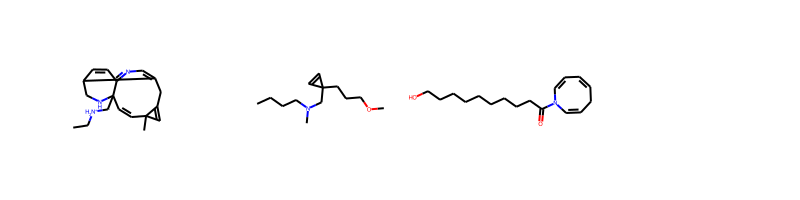

In [56]:
syntax_val_new={0:[], 1:[]}


smi_reconst_new=[]
smi_reconst_new_valid=[]

mols_reconst_new= []
mols_reconst_new_valid=[]

n_mol=10000

latent_samples= np.random.normal(0,1,size=(n_mol,Z_DIM))

#Passing it to Decoder
reconst_sample = decoder.predict(latent_samples)
reconst_smi=reconst_sample.reshape(n_mol, mol_size_x, mol_size_y) 

for id, latent_mol in enumerate(reconst_smi):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_smi[id,:,:], axis=1)])
  smi = re.sub('!|E',"", smi)
  smi_reconst_new.append(smi)

  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_new.append(mol)
  if mol is None:
    syntax_val_new[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val_new[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid New Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)      
    except:
      print('Mol {} {}'.format(id+1, mol)) 

i=1
for item in syntax_val_new[1]:
  smi_reconst_new_valid.append(smi_reconst_new[item].rstrip('\n'))
  mols_reconst_new_valid.append(mols_reconst_new[item])
  print("New valid Molecule", i, smi_reconst_new[item], "Index=", item)
  i=i+1

print(len(mols_reconst_new_valid), "New Valid Molecules")
Draw.MolsToGridImage(mols_reconst_new_valid, molsPerRow=4,subImgSize=(200,200))


# **Property Acceptance of Newly Generated Valid Molecules**

In [57]:
# Calculating mean and standard deviation of all property values on test data

qed_mean_test= np.mean(y_test_property, axis=0)
qed_std_test = np.std(y_test_property, axis=0)
print("Mean of qed Property Value", qed_mean_test)
print("Standard Deviation of qed Property Value", qed_std_test)

# Predicting Properties of New Valid Molecules

predicted_prop_samples=predictor.predict(latent_samples[syntax_val_new[1]])


for ((id,item), val_mol_id) in zip(enumerate(predicted_prop_samples), syntax_val_new[1]):
  # print(id)
  e=predicted_prop_samples[id][0]<(qed_mean_test+qed_std_test)
  f=predicted_prop_samples[id][0]>=(qed_mean_test-qed_std_test)
  print("Predicted Properties of molecule having index ", val_mol_id,"is", predicted_prop_samples[id][0])
  if (e & f):
    print("Mol {}, Property Validated".format(val_mol_id))    
  else:    
    print("Mol {}, Property Invalidated".format(val_mol_id))  
  

Mean of qed Property Value [0.73655089]
Standard Deviation of qed Property Value [0.13490828]
Predicted Properties of molecule having index  3220 is 0.8154888
Mol 3220, Property Validated
Predicted Properties of molecule having index  5441 is 0.62609243
Mol 5441, Property Validated
Predicted Properties of molecule having index  9196 is 0.6694626
Mol 9196, Property Validated


In [ ]:
# print(syntax_val_new[1])
# print(predicted_prop_samples.shape)
# print(predicted_prop_samples)
# print(type(predicted_prop_samples))
